# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Frameworks</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


## Estudo de Caso - Forecast de Vendas com GluonTS

Gluon Time Series é uma biblioteca para modelagem de séries temporais baseada em Deep Learning. O GluonTS simplifica o desenvolvimento e a experimentação de modelos de séries temporais para tarefas comuns, como previsão ou detecção de anomalias. Ele fornece todos os componentes e ferramentas necessários que os Cientistas de Dados precisam para criar rapidamente novos modelos, executar e analisar experimentos com eficiência e avaliar a precisão do modelo.

Gluon Time Series (GluonTS) é o kit de ferramentas Gluon para modelagem probabilística de séries temporais, com foco em modelos baseados em Deep Learning.

O GluonTS fornece utilitários para carregar e iterar conjuntos de dados de séries temporais, modelos prontos pré-treinados e blocos de construção para definir seus próprios modelos e experimentar rapidamente soluções diferentes. Com o GluonTS você pode:

- Treinar e avaliar qualquer um dos modelos internos com seus próprios dados e encontrar rapidamente uma solução para suas tarefas de análise de séries temporais.

- Usar abstrações e blocos de construção fornecidos para criar modelos de séries temporais personalizados e fazar uma comparação rápida com os algoritmos de linha de base.

O GluonTS é executado sobre o framework para Deep Learning MxNet, que foi desenvolvido pela Amazon e hoje é um projeto open-source.

Vamos experimentar o GluonTS em nosso problema de séries temporais. Visite o site oficial aqui:

https://gluon-ts.mxnet.io/


## Definição do Problema

Neste trabalho vamos criar um modelo de previsões para série temporal capaz de prever as vendas de um livro ao longo do tempo. A descrição dos dados está na sequência deste Jupyter Notebook.

In [2]:
!nvidia-smi

Tue May 12 18:27:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   38C    P8     9W / 250W |    114MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   34C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Instalamos a versão MXNET para suporte à plataforma CUDA que usamos no Titan, versão 10.2
# Isso habilita o MxNet para ser executado com GPU.
!pip install -q mxnet-cu102

In [5]:
# Agora instalamos o GluonTS
!pip install -q gluonts

In [6]:
# Imports
import mxnet
import gluonts
import numpy as np
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
from itertools import islice
from gluonts.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
m.style.use('ggplot')
%matplotlib inline

In [7]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

numpy      1.18.4
matplotlib 3.2.1
mxnet      1.6.0
gluonts    0.5.0
pandas     1.0.3
Data Science Academy


### Carregando os Dados

In [8]:
# Carrega o dataset
dados_vendas = pd.read_csv('dados/datasets/vendas.csv', header = 0, index_col = 0)

In [9]:
# Shape
dados_vendas.shape

(15831, 1)

In [10]:
# Visualiza os dados
dados_vendas.head()

,vendas
data,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


Observe na tabela acima que temos uma série tempora univariada. Ou seja, temos um fenômeno que ocorre ao longo do tempo, nesse caso o número de livros vendidos a cada intervalo de tempo (5 minutos em nosso exemplo). Caso tivéssemos mais de um fenômeno, como venda de livros e canetas, a série seria multivariada.

Perceba que a coluna de data não é uma variável no dataset, mas sim um índice que indica a evolução da variável ao longo do tempo.

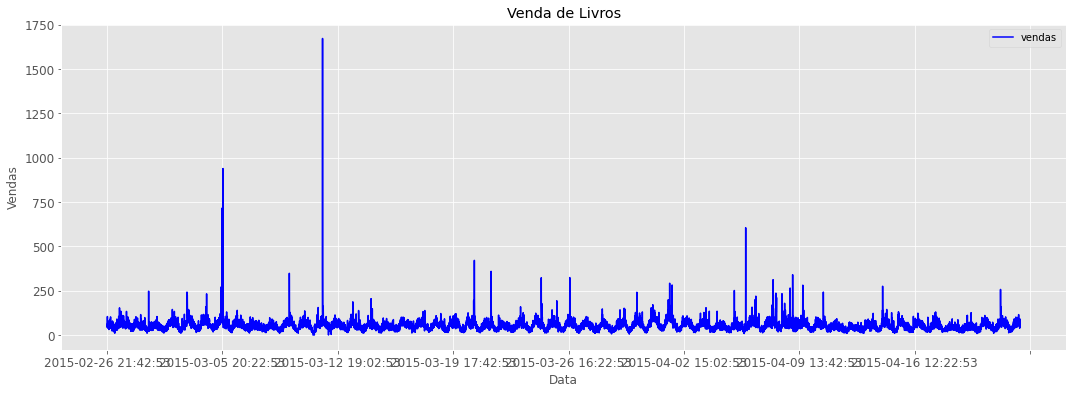

In [11]:
# Vamos criar um plot para nossa série
ax = dados_vendas.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Livros")
plt.show()

Como a série é muito densa (muitos registros), vamos criar um plot com 200 registros.

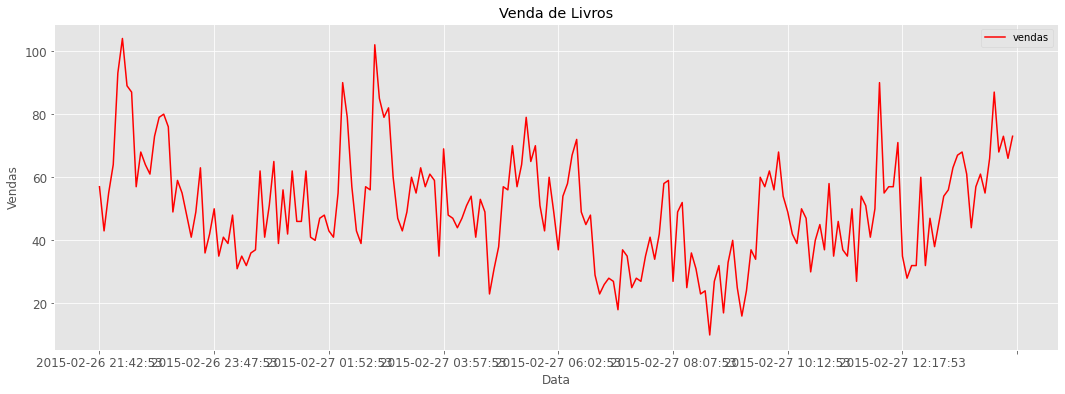

In [12]:
# Vamos criar um plot para 200 registros da noss série série
ax = dados_vendas[:200].plot(color = 'r', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Livros")
plt.show()

Agora fica mais fácil visualizar os padrões da série. Vamos então preparar os dados de treino e teste.

### Preparação dos Dados de Treino e Teste

Usamos a função ListDataset() do GluonTS e criamos a série temporal com a data de inícios (start) e o target (data final).

Compreenda isso aqui: 

"start": dados_vendas.index[0]

"target": dados_vendas.value[:"2015-04-05 00:00:00"]

Estamos coletando todos os registros da série até target e usaremos como dados de entrada. Ou seja, start representa x e target é o nosso y. Aprendendo sobre o comportamento das séries anteriores, conseguimos prever o comportamento de uma série posterior.

Observe ainda que a frequência é de 5 minutos.

In [13]:
# Dataset de treino
dados_treino = ListDataset([{"start": dados_vendas.index[0], 
                             "target": dados_vendas.vendas[:"2015-04-05 00:00:00"]}],
                           freq = "5min")

Para os dados de teste, tudo que precisamos é de alguns registros com algumas séries.

In [14]:
# Dataset de teste
dados_teste = ListDataset([{"start": dados_vendas.index[0], "target": dados_vendas.vendas[:"2015-04-10 03:00:00"]},
                           {"start": dados_vendas.index[0], "target": dados_vendas.vendas[:"2015-04-15 18:00:00"]},
                           {"start": dados_vendas.index[0], "target": dados_vendas.vendas[:"2015-04-20 12:00:00"]}],
                          freq = "5min")

### Construção do Modelo

In [15]:
# Criação do modelo com DeepAR (Deep Autoregressive Model)
# Vamos teinar com 36 períodos (36 time points, ou 3 horas em nossa série) de tempo para as previsões e por 10 épocas
estimator = DeepAREstimator(freq = "5min", prediction_length = 36, trainer = Trainer(epochs = 10))

### Treinamento do Modelo

In [16]:
%%time
modelo = estimator.train(training_data = dados_treino)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:04<00:00, 10.44it/s, epoch=10/10, avg_epoch_loss=3.98]

CPU times: user 1min, sys: 2.67 s, total: 1min 2s
Wall time: 57.8 s


### Avaliação do Modelo

In [17]:
# Função para as previsões
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize = (18, 6), linewidth = 2)
        forecast.plot(color = 'g')
        plt.grid(which = 'both')
        plt.legend(["Vendas Observadas", 
                    "Mediana das Previsões", 
                    "Intervalo de Confiana de 90%", 
                    "Intervalo de Confiana de 50%"])
        plt.show()

In [18]:
# Extrai as previsões
forecast_it, ts_it = make_evaluation_predictions(dados_teste, predictor = modelo, num_samples = 100)

In [19]:
# Converte os resultados em listas
forecasts = list(forecast_it)
tss = list(ts_it)

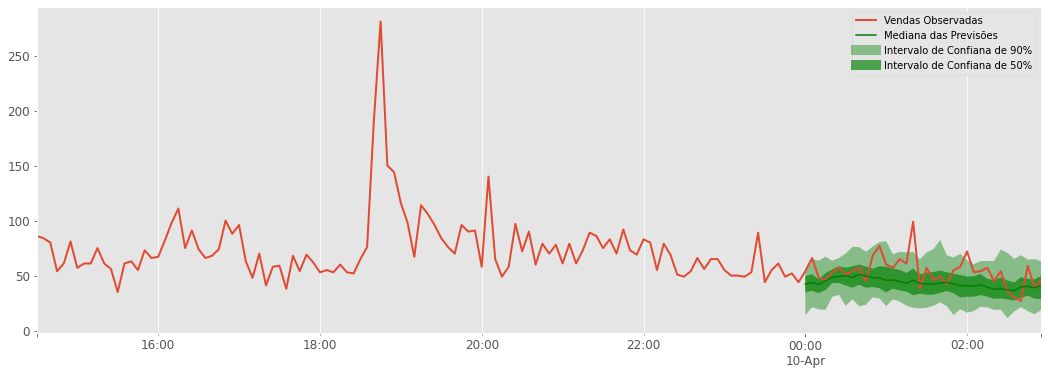

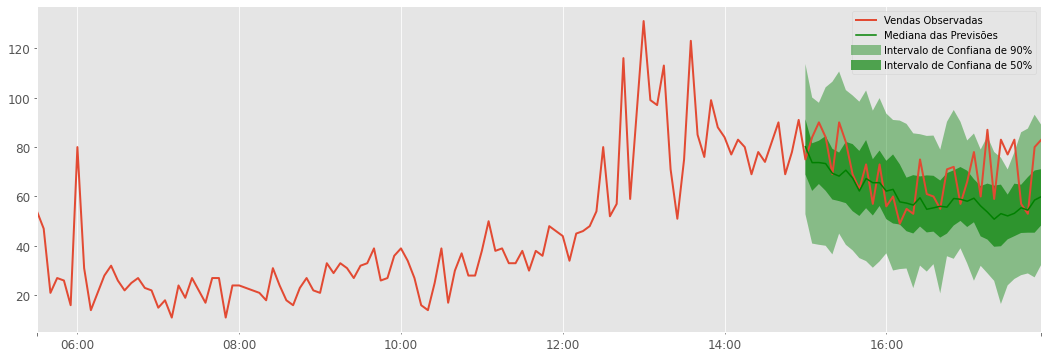

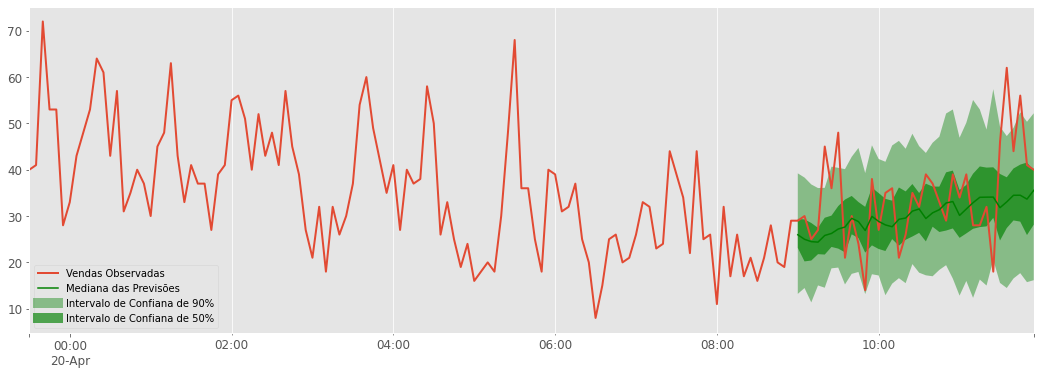

In [20]:
# Plot
plot_forecasts(tss, forecasts, past_length = 150, num_plots = 3)

Visualmente o modelo apresenta boa performance, mas vamos calcular as métricas.

In [21]:
# Criamos o avaliador
evaluator = Evaluator(quantiles = [0.5], seasonality = 2016)

In [22]:
# Aplicamos o avaliador e extraímos as métricas
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series = len(dados_teste))

Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 11.44it/s]


In [23]:
# Vamos analisar as métricas agregadas
agg_metrics

{'MSE': 184.4686121057581,
 'abs_error': 1103.3702392578125,
 'abs_target_sum': 5658.0,
 'abs_target_mean': 52.38888888888889,
 'seasonal_error': 18.833625618877182,
 'MASE': 0.542043430675928,
 'MAPE': 0.1942665276154257,
 'sMAPE': 0.20948920277580477,
 'OWA': nan,
 'MSIS': 21.681738668783453,
 'QuantileLoss[0.5]': 1103.3702583312988,
 'Coverage[0.5]': 0.25925925925925924,
 'RMSE': 13.581922253707614,
 'NRMSE': 0.25925196242495974,
 'ND': 0.19501064674051122,
 'wQuantileLoss[0.5]': 0.1950106501115763,
 'mean_wQuantileLoss': 0.1950106501115763,
 'MAE_Coverage': 0.24074074074074076}

Ao analisar as métricas de series temporais, observamos principalmente o RMSE e o MAPE. Mas como saber se os valores estão bons? Como essas métricas indicam o erro o modelo, quanto menor, melhor, mas como saber se já estamos em um nível satisfatório?

Uma boa alternativa, é criar um modelo mais simples e comparar. Esperamos que nosso modelo tenha uma performance melhor que um modelo simples. Vamos fazer isso.

In [24]:
# Cria um modelo Naive (ingênuo), um modelo simples de previsão de séries temporais.
seasonal_predictor_1W = SeasonalNaivePredictor(freq = "5min", prediction_length = 36, season_length = 2016)

In [25]:
# Extraímos as métricas do modelo simples
forecast_it, ts_it = make_evaluation_predictions(dados_teste, predictor = seasonal_predictor_1W, num_samples = 100)

In [26]:
# Converte os resultados em listas
forecasts = list(forecast_it)
tss = list(ts_it)

In [27]:
# Aplicamos o avaliador e extraímos as métricas
agg_metrics_seasonal, item_metrics_seasonal = evaluator(iter(tss), iter(forecasts), num_series = len(dados_teste))

Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 11.17it/s]


In [28]:
# Concatenamos as métricas dos 2 modelos criados em um único dataframe
df_metricas = pd.DataFrame.join(pd.DataFrame.from_dict(agg_metrics, 
                                                      orient = 'index').rename(columns = {0: "Modelo DeepAR"}),
                               pd.DataFrame.from_dict(agg_metrics_seasonal, 
                                                      orient='index').rename(columns={0: "Modelo Naive Simples"}))

In [29]:
# Viualizamos o resultado
df_metricas.loc[["MAPE", "RMSE"]]

,Modelo DeepAR,Modelo Naive Simples
MAPE,0.194267,0.387725
RMSE,13.581922,28.481475


Agora sim. Fica evidente que nosso modelo tem uma performance superior a um modelo simples.

Par atentar melhorar o modelo, experimente ajustar os hiperparâmetros.

# Fim